# 순서
1. 구매 주기 만들기
2. retention 만들기
*   가입년월일 데이터 만들기 (최고 구매일을 가입년월로 정의)
*   월단위 데이터 요약 만들기 (매월 주문 횟수)
*   Join 을 통해서 다음달 구매를 구매자 요약 데이터 만들기
*   비율로 만들어 retention 만들기


```
# 코드로 형식 지정됨
```








# **1.환경설정**
**분석에 사용할 라이브러리 불러오기 및 구글 드라이브 연결**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. 데이터 확인**
**데이터 불러온 후 데이터 형태 확인**

In [3]:
df = pd.read_excel('/content/drive/MyDrive/[러닝스푼즈] CRM 프로젝트/[러닝스픈즈] CRM머신러닝 프로젝트_3기/6주차 /Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [5]:
# 전체적인 데이터 수 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# **3. 데이터 준비**


In [6]:
# 거래액 데이터 생성
df['Sales']= df['UnitPrice'] * df['Quantity']

## 3.1 최초 주문일 정보를 이용하여 유저의 가입데이터 생성

In [7]:
# user info data frame 생성
user_info = df.groupby(['CustomerID','Country']).InvoiceDate.min()
user_info = user_info.reset_index()   # group by의 기준이 되었던 컬럼이 index 로 잡히기 때문에 이를 해제 하기 위해서
user_info['JoinYM'] = pd.DatetimeIndex(user_info['InvoiceDate']).to_period('M')

user_info.head()

,CustomerID,Country,InvoiceDate,JoinYM
0,12346.0,United Kingdom,2011-01-18 10:01:00,2011-01
1,12347.0,Iceland,2010-12-07 14:57:00,2010-12
2,12348.0,Finland,2010-12-16 19:09:00,2010-12
3,12349.0,Italy,2011-11-21 09:51:00,2011-11
4,12350.0,Norway,2011-02-02 16:01:00,2011-02


## 3.2 거래 정보를 월별로 요약

In [8]:
# 월별 거래 정보 생성

# 월별 주문금액 및 주문 횟수 요약
df['OrderYM'] = pd.DatetimeIndex(df['InvoiceDate']).to_period('M')
smr_m = df.groupby(['CustomerID','OrderYM']).agg(
 # Slaes = ('Sales','sum'),
  OrderCNT = ('InvoiceNo','nunique')
)

smr_m = smr_m.reset_index()

smr_m.head()

,CustomerID,OrderYM,OrderCNT
0,12346.0,2011-01,2
1,12347.0,2010-12,1
2,12347.0,2011-01,1
3,12347.0,2011-04,1
4,12347.0,2011-06,1


# **4. 리텐션 계산**

## 4.1 M+1 구매 리텐션 생성

In [9]:
# 최초 주문일 기준 익월 구매 유저를 생성

user_info['JoinM1'] = pd.DatetimeIndex(user_info['InvoiceDate']).to_period('M')+1
m1_retention = pd.merge(user_info, smr_m, how ="left", left_on = ['CustomerID','JoinM1'], right_on = ['CustomerID','OrderYM'])
m1_retention.head()

,CustomerID,Country,InvoiceDate,JoinYM,JoinM1,OrderYM,OrderCNT
0,12346.0,United Kingdom,2011-01-18 10:01:00,2011-01,2011-02,NaT,NaN
1,12347.0,Iceland,2010-12-07 14:57:00,2010-12,2011-01,2011-01,1.0
2,12348.0,Finland,2010-12-16 19:09:00,2010-12,2011-01,2011-01,1.0
3,12349.0,Italy,2011-11-21 09:51:00,2011-11,2011-12,NaT,NaN
4,12350.0,Norway,2011-02-02 16:01:00,2011-02,2011-03,NaT,NaN


In [10]:
# 구매 유저수 요약
m1_retention = m1_retention.groupby('JoinYM').agg(
    m_0 = ('CustomerID','count'),
    m_1 = ('OrderCNT','count')
)
m1_retention.head()

,m_0,m_1
JoinYM,,
2010-12,949,362
2011-01,421,101
2011-02,381,94
2011-03,440,84
2011-04,301,68


In [11]:
# 익월 구매 유저 비율 생성
join_uu = m1_retention['m_0']
m1_retention['m_0'] = m1_retention['m_0']
m1_retention['m_1'] = m1_retention['m_1']/join_uu
m1_retention

,m_0,m_1
JoinYM,,
2010-12,949,0.381454
2011-01,421,0.239905
2011-02,381,0.246719
2011-03,440,0.190909
2011-04,301,0.225914
2011-05,279,0.236559
2011-06,237,0.210970
2011-07,191,0.209424
2011-08,167,0.251497


## 4.2 M+6 까지 리텐션 생성


In [12]:
# for 문을 사용하여 6개월 데이터 생성
retention = user_info

for i in range(1,7):
  retention['JoinNextM'] = pd.DatetimeIndex(retention['InvoiceDate']).to_period('M')+i  # 다음월 생성 (join 할 때 key 생성)
  retention = pd.merge(retention, smr_m, how ="left", left_on = ['CustomerID','JoinNextM'], right_on = ['CustomerID','OrderYM'])
  retention.rename(columns= {'OrderCNT': 'OrderCNT_'+ str(i)}, inplace = True)
  retention.drop(columns =['OrderYM'], inplace =True)

retention.head()

,CustomerID,Country,InvoiceDate,JoinYM,JoinM1,JoinNextM,OrderCNT_1,OrderCNT_2,OrderCNT_3,OrderCNT_4,OrderCNT_5,OrderCNT_6
0,12346.0,United Kingdom,2011-01-18 10:01:00,2011-01,2011-02,2011-07,NaN,NaN,NaN,NaN,NaN,NaN
1,12347.0,Iceland,2010-12-07 14:57:00,2010-12,2011-01,2011-06,1.0,NaN,NaN,1.0,NaN,1.0
2,12348.0,Finland,2010-12-16 19:09:00,2010-12,2011-01,2011-06,1.0,NaN,NaN,1.0,NaN,NaN
3,12349.0,Italy,2011-11-21 09:51:00,2011-11,2011-12,2012-05,NaN,NaN,NaN,NaN,NaN,NaN
4,12350.0,Norway,2011-02-02 16:01:00,2011-02,2011-03,2011-08,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# 매월 구매 유저수 요약
retention_m6 = retention.groupby('JoinYM').agg(
    M_0 = ('CustomerID','count'),
    M_1 = ('OrderCNT_1','count'),
    M_2 = ('OrderCNT_2','count'),
    M_3 = ('OrderCNT_3','count'),
    M_4 = ('OrderCNT_4','count'),
    M_5 = ('OrderCNT_5','count'),
    M_6 = ('OrderCNT_6','count'),
)

retention_m6

,M_0,M_1,M_2,M_3,M_4,M_5,M_6
JoinYM,,,,,,,
2010-12,949,362,317,368,341,376,360
2011-01,421,101,119,102,138,126,110
2011-02,381,94,73,107,103,95,98
2011-03,440,84,112,96,102,78,116
2011-04,301,68,68,63,63,71,70
2011-05,279,66,48,48,60,68,74
2011-06,237,50,45,66,58,79,24
2011-07,191,40,39,44,52,22,0
2011-08,167,42,42,42,23,0,0


In [14]:
# 비율로 변환 (월별 가입자 수로 나눠줌)
retention_m6 = retention_m6.divide(retention_m6['M_0'], axis=0)
retention_m6

,M_0,M_1,M_2,M_3,M_4,M_5,M_6
JoinYM,,,,,,,
2010-12,1.0,0.381454,0.334036,0.387777,0.359326,0.396207,0.379347
2011-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283
2011-02,1.0,0.246719,0.191601,0.280840,0.270341,0.249344,0.257218
2011-03,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636
2011-04,1.0,0.225914,0.225914,0.209302,0.209302,0.235880,0.232558
2011-05,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233
2011-06,1.0,0.210970,0.189873,0.278481,0.244726,0.333333,0.101266
2011-07,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,0.000000
2011-08,1.0,0.251497,0.251497,0.251497,0.137725,0.000000,0.000000


<Axes: ylabel='JoinYM'>

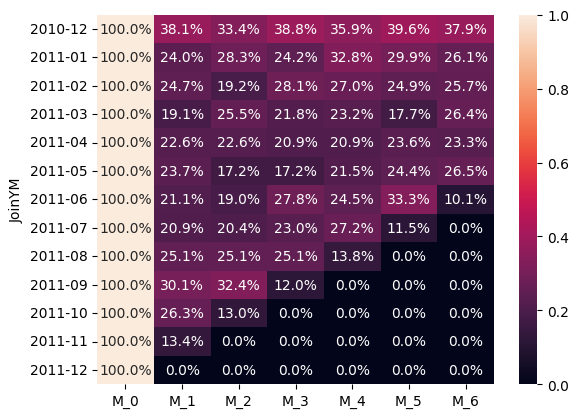

In [15]:
# 시각화
sns.heatmap(data=retention_m6, annot = True, fmt = '.1%')